<a href="https://colab.research.google.com/github/luchosic/SOA/blob/main/Cuaderno_1_grupo3_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Introducción

El siguiente ejemplo modifica el color de una imagen parametrizada, para que sea más brillante. El cálculo se realiza convirtiendo los 3 canales RGB, que representan a los colores R (*rojo*)-G(*verde*)-B(*azul*), de cada pixel siguiendo la ecuación:

<center><br>$ Pixel= (R*2, G*2, B*2)$</center></br>

*El valor por el que se multiplica a cada componente es variable, depende de cuanto más brillante se desee hacer a la imagen.*

<br>Para evitar que alguno de los componentes se pase de 255, y el programa arroje un warning, se utiliza la función MIN, de modo que se tome el mínimo valor entre 255 y el valor del canal RGB luego de aplicada la transformación.


---
# 2 Armado del ambiente
Toma la dirección web de una imagen con acceso público en internet, la deja disponible al contexto de ejecución del cuaderno Colab.

In [63]:
#@title ## 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://github.com/luchosic/SOA/blob/main/HPC/image/montanas-en-patagonia-argentina-4273.jpg?raw=true" #@param {type:"string"}

!wget {url_imagen} -O imagen.jpg

#Verificación de la correcta carga de la imagen
img_nombre = 'imagen.jpg'
try:
    Image.open(img_nombre)
    print('Listo! Su imagen se encuentra lista para ser procesada')
except Exception:
    print('No se ha ingresado una URL correcta. Intente de nuevo')


--2021-11-21 14:15:25--  https://github.com/luchosic/SOA/blob/main/HPC/image/montanas-en-patagonia-argentina-4273.jpg?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/luchosic/SOA/raw/main/HPC/image/montanas-en-patagonia-argentina-4273.jpg [following]
--2021-11-21 14:15:25--  https://github.com/luchosic/SOA/raw/main/HPC/image/montanas-en-patagonia-argentina-4273.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/luchosic/SOA/main/HPC/image/montanas-en-patagonia-argentina-4273.jpg [following]
--2021-11-21 14:15:25--  https://raw.githubusercontent.com/luchosic/SOA/main/HPC/image/montanas-en-patagonia-argentina-4273.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...


# 3 Desarrollo CPU

Imagen del filtro: imagen.jpg -RGB- [3840, 2160]


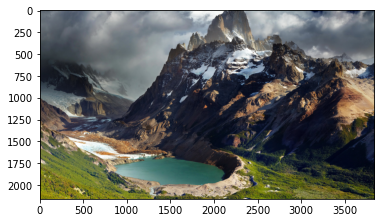

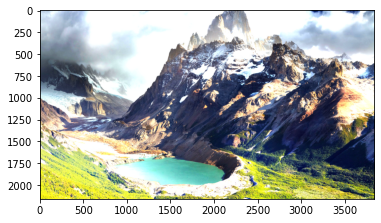

In [82]:
 %matplotlib inline
from datetime import datetime

tiempo_total_cpu = datetime.now()

import  matplotlib.pyplot as plt
import numpy
from PIL import Image 

#@title ## 3.1 Parámetros
#@markdown ---
#@markdown ### Brillo deseado a aplicar en la imagen:
nivel_de_brillo =  2#@param {type:"number"}

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# Optengo las proporsiones de la imagen. 
img_ancho, img_alto = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array.
img_pic_cpu = numpy.asarray(image)
img_pic_cpu = img_pic_cpu.astype( numpy.int32() )

# Genero el array resultado (3 pixeles usa RGB * (el tamaño del array)).
img_picR_cpu = numpy.empty_like( img_pic_cpu)

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

plt.figure()
imgplot=plt.imshow( img_pic_cpu )

tiempo_img_cpu = datetime.now()

# Subo brillo a imagen
for y  in range( 0, img_alto ):
  for x in range( 0, img_ancho ):

    pixel_R, pixel_G, pixel_B = img_pic_cpu[y][x]

    r = min(255, pixel_R * nivel_de_brillo)
    g = min(255, pixel_G * nivel_de_brillo)
    b = min(255, pixel_B * nivel_de_brillo)  

    img_picR_cpu[y][x] = [r, g, b]

tiempo_img_cpu = datetime.now() - tiempo_img_cpu

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot = plt.imshow( img_picR_cpu )

tiempo_total_cpu = datetime.now() - tiempo_total_cpu

# 4 Desarrollo GPU

# 4.1 Instala en el cuaderno el módulo CUDA de Python.

In [4]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 75 kB 4.2 MB/s 
     |████████████████████████████████| 66 kB 4.6 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627871 sha256=28f01bce2405e109308dfc39e483a17265deea326d60e26160419896d8b8c4ce
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.9-py2.py3-none-any.whl size=62370 sha256=300a9dc852bc2e9c2d2445371dd81feb4e4064c9e0e4d3f08b1506c2ca6eb208
  Stored in directory: /root/.cache/pip/wheels/41/b9/6e/94bb014f6484b15ec77e7877f3a227609481ffd98db364504d
Successfully built pycuda pytools


# 4.2 Procesamiento con GPU

Imagen del filtro: imagen.jpg -RGB- [3840, 2160]


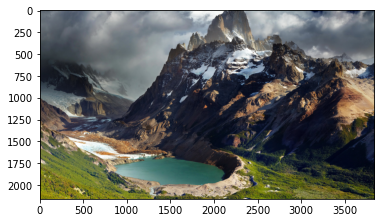

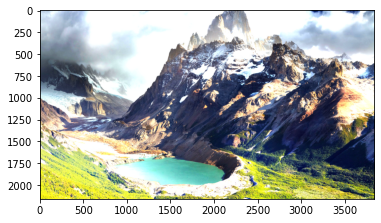

In [110]:
%matplotlib inline
from datetime import datetime
tiempo_total_gpu = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

#@title ## 4.2.1 Parámetros
#@markdown ---
#@markdown ### Brillo deseado a aplicar en la imagen:
nivel_de_brillo =  2#@param {type:"number"}

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# Optengo las proporsiones de la imagen. 
img_ancho, img_alto  = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_O_cpu = img_O_cpu.astype( numpy.int32() )
img_R_cpu = numpy.empty_like( img_O_cpu)

# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
  int min(int a, int b){
    return (a > b) ? b : a;
  }

__global__ void kernel_img( int ancho, int alto, int *img_O, int *img_R, int nivel_de_brillo )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  float r = 0.0;
  float g = 0.0;
  float b = 0.0;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
    // Calculo el brillo para el pixel a partir de los componentes.
    r = (float)min(255, img_O[(idx+(idy*ancho))*3]*nivel_de_brillo);   // Componente Rojo del pixel.
    g = (float)min(255, img_O[((idx+(idy*ancho))*3)+1]*nivel_de_brillo);  // Componente Verde del pixel.
    b = (float)min(255, img_O[((idx+(idy*ancho))*3)+2]*nivel_de_brillo);   // Componente Azul del pixel.
    // Escribo el color del pixel.
    img_R[(idx+(idy*ancho))*3  ] = (int) r;
    img_R[(idx+(idy*ancho))*3+1] = (int) g;
    img_R[(idx+(idy*ancho))*3+2] = (int) b;
  }
}
""") 

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

tiempo_img_gpu = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

tiempo_img_gpu = datetime.now()

kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, numpy.int32(nivel_de_brillo), block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img_gpu = datetime.now() - tiempo_img_gpu

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total_gpu = datetime.now() - tiempo_total_gpu

# 5 Métricas

In [111]:
from tabulate import tabulate
data = [['Tiempo de aplicado de filtro', tiempo_img_cpu, tiempo_img_gpu],
['Tiempo total de procesamiento', tiempo_total_cpu, tiempo_total_gpu]]
print (tabulate(data, headers=["Métrica", "CPU", "GPU"]))

print( "\n\nDatos de corrida con CPU:" )
print("Cantidad de ciclos realizados: ", img_ancho * img_alto)

print( "\n\nDatos de corrida con GPU:" )
print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )




Métrica                        CPU             GPU
-----------------------------  --------------  --------------
Tiempo de aplicado de filtro   0:01:46.372136  0:00:00.000182
Tiempo total de procesamiento  0:01:46.927924  0:00:00.590029


Datos de corrida con CPU:
Cantidad de ciclos realizados:  8294400


Datos de corrida con GPU:
Thread: [ 16 , 19  ], Bloque : [ 240 , 114 ]
Total de Thread: [ 3840 , 2166  ]  =  8317440


---
# 6 Conclusiones

Al procesar una imagen, en este caso para subirle su nivel de brillo, podemos observar claramente como difiere la ejecución utilizando CPU o al aplicar GPU. <br>
Utilizamos una imgen 1080p para que la diferencia de tiempos sea clara. Mientras que a la CPU le toma alrededor de 2 minutos hacerlo de modo secuencial, con GPU, al utilizar un hilo por cada pixel, solo le lleva 4 segundos o menos. <br>
Esto deja en evidencia el gran beneficio que trae el uso de GPU al momento de procesar una imagen.

---
# 7 Bibliografía



1.   Bibliografía de la materia SOA de la Universidad Nacional de la Matanza, sobre convertir una imagen a escala de grises (CPU): [Página Github](https://github.com/wvaliente/SOA_HPC/blob/main/Ejercicios/Prueba%202%20-%20Imagen%20-%20CPU.ipynb)
2.   Bibliografía de la materia SOA de la Universidad Nacional de la Matanza, sobre convertir una imagen a escala de grises (GPU): [Página Github](https://github.com/wvaliente/SOA_HPC/blob/main/Ejercicios/Prueba%202%20-%20Imagen%20-%20GPU.ipynb) 
3.   Página sobre Luz y Color: [Página Online](https://lodev.org/cgtutor/color.html#Change_the_Brightness_)
4.   Array types and conversions between types: [Página Online](https://numpy.org/doc/stable/user/basics.types.html)


